In [1]:
%pip install pandas numpy seaborn tensorflow
%pip install nltk
%pip install lime
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt


from lime import lime_text
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

# Camada de Atenção (Mover para antes da definição do modelo)
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(name='att_W', shape=(input_shape[-1], 1), initializer='normal', trainable=True)
        self.b = self.add_weight(name='att_b', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_u', shape=(input_shape[1], 1), initializer='normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et, axis=1)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        output = K.sum(output, axis=1)
        self.attention_weights = at  # Armazenar os pesos para visualização
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = super().get_config().copy()
        return config

In [3]:
df = pd.read_csv('../spam.csv')

In [4]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.shape

(5572, 2)

<Axes: xlabel='Category', ylabel='count'>

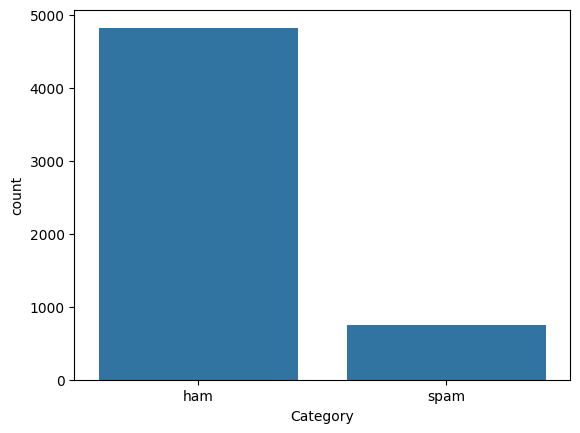

In [7]:
sns.countplot(x='Category', data=df)

**Pré-Processamento**

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Baixar pacotes necessários do NLTK
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('punkt_tab') # Download the 'punkt_tab' resource

[nltk_data] Downloading package stopwords to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [9]:
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()

    # Remover caracteres especiais e números
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenização (dividir em palavras)
    tokens = word_tokenize(text)

    # Remover stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematização (reduzir palavras à sua forma base)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Juntar as palavras processadas de volta em uma string
    return " ".join(tokens)

In [11]:
df["clean_text"] = df["Message"].apply(preprocess_text)

In [12]:
df.head(5)

,Category,Message,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


<Axes: xlabel='Category', ylabel='count'>

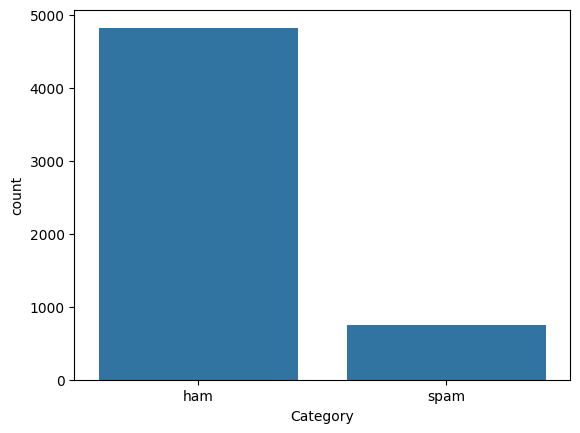

In [13]:
sns.countplot(x="Category", data=df) # validando se mudou as classes

In [14]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['Category'])

In [15]:
X = df['clean_text']
y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#, stratify=y

In [16]:
#tokenização e padding
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

**LSTM**

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [18]:
# Definir o modelo LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))  # LSTM com retorno de sequências para atenção
model.add(AttentionLayer())  # Adicionar a camada de atenção
model.add(Dense(3, activation='softmax'))  # 3 saídas para sentimentos (negativo, neutro, positivo)

c:\Users\LUIRYS SILVA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
# Compilar o modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy se y_train for numérico
              metrics=['accuracy'])

In [20]:
# Treinar o modelo
history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)  # Validação durante o treinamento

Epoch 1/10


c:\Users\LUIRYS SILVA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:870: UserWarning: Gradients do not exist for variables ['sequential/attention_layer/att_u'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


126/126 ━━━━━━━━━━━━━━━━━━━━ 89s 627ms/step - accuracy: 0.8975 - loss: 0.2882 - val_accuracy: 0.9574 - val_loss: 0.1686
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 493ms/step - accuracy: 0.9776 - loss: 0.0809 - val_accuracy: 0.9641 - val_loss: 0.1046
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 75s 438ms/step - accuracy: 0.9870 - loss: 0.0450 - val_accuracy: 0.9664 - val_loss: 0.1074
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 434ms/step - accuracy: 0.9923 - loss: 0.0313 - val_accuracy: 0.9686 - val_loss: 0.1020
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 117s 703ms/step - accuracy: 0.9943 - loss: 0.0231 - val_accuracy: 0.9686 - val_loss: 0.0987
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 116s 489ms/step - accuracy: 0.9958 - loss: 0.0187 - val_accuracy: 0.9709 - val_loss: 0.1040
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 75s 430ms/step - accuracy: 0.9965 - loss: 0.0157 - val_accuracy: 0.9753 - val_loss: 0.1000
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 90s 490ms/step - accuracy: 0.9970 - loss: 0.0146 - v

**UNDERSAMPLING**

In [21]:
from imblearn.under_sampling import RandomUnderSampler

# Inicializar o RandomUnderSampler
rus = RandomUnderSampler(random_state=42) # random_state para reprodutibilidade

# Aplicar o undersampling aos dados de treino
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_pad, y_train)

In [22]:
# Treinar o modelo com os dados balanceados
history = model.fit(X_train_resampled, y_train_resampled,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 432ms/step - accuracy: 0.9944 - loss: 0.0170 - val_accuracy: 0.9250 - val_loss: 0.2341
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 380ms/step - accuracy: 0.9963 - loss: 0.0144 - val_accuracy: 0.9000 - val_loss: 0.4343
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 385ms/step - accuracy: 0.9963 - loss: 0.0144 - val_accuracy: 0.9250 - val_loss: 0.2385
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 547ms/step - accuracy: 0.9963 - loss: 0.0148 - val_accuracy: 0.9083 - val_loss: 0.2903
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 646ms/step - accuracy: 0.9963 - loss: 0.0127 - val_accuracy: 0.9000 - val_loss: 0.3394
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 713ms/step - accuracy: 0.9963 - loss: 0.0128 - val_accuracy: 0.9000 - val_loss: 0.3705
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 36s 539ms/step - accuracy: 0.9963 - loss: 0.0114 - val_accuracy: 0.9000 - val_loss: 0.3719
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 539ms/step - accuracy: 0.9963 - loss: 0.0113 - val_accu

<Axes: xlabel='label_encoded', ylabel='count'>

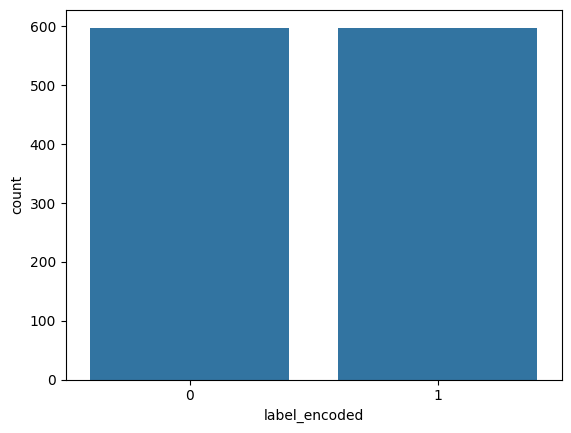

In [23]:
#verificar a nova distribuição de classes
sns.countplot(x=y_train_resampled)

**Métricas**

In [24]:
from sklearn.metrics import classification_report

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerar o relatório de classificação
print(classification_report(y_test, y_pred_classes))


35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.93      0.91      0.92       149

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [25]:
#acuracia,precisão, recall e f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1
# Calcular as métricas
accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred_classes)
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Acurácia: 0.9785
Precisão: 0.9784
Recall: 0.9785
F1-Score: 0.9784


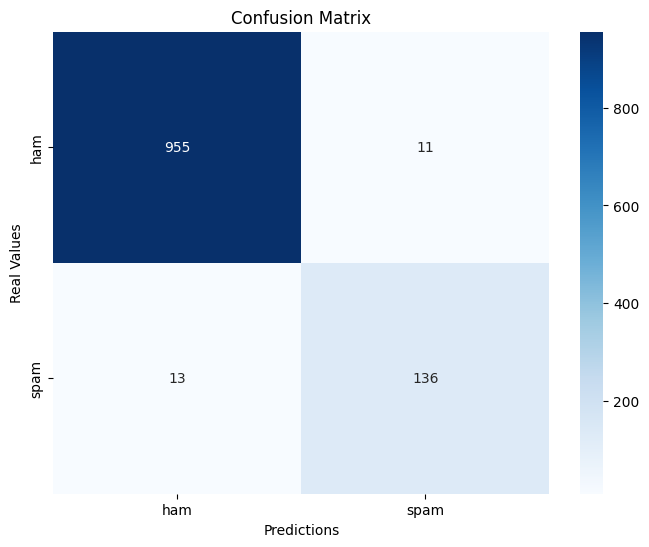

In [26]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Criar o heatmap da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predictions")
plt.ylabel("Real Values")
plt.title("Confusion Matrix")
plt.show()

**LIME**

In [27]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=le.classes_)

def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    predictions = model.predict(padded_sequences)
    return predictions  # Já retorna probabilidades (softmax)

# Solicita ao usuário o número da linha do exemplo
idx = int(input(f"Digite o número da linha (0 a {len(X_test)-1}): "))
sample_text = X_test.iloc[idx]
sample_label = y_test.iloc[idx]

# Predição da classe para o texto selecionado
sample_seq = tokenizer.texts_to_sequences([sample_text])
sample_pad = pad_sequences(sample_seq, maxlen=max_len)
pred_probs = model.predict(sample_pad)
pred_class_idx = pred_probs.argmax(axis=1)[0]
pred_class_name = le.classes_[pred_class_idx]

print(f"Número da linha no X_test: {idx}")
print(f"Original text:\n{sample_text}")
print(f"Classe real: {le.classes_[sample_label]}")
print(f"Classe predita: {pred_class_name}")

explanation = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10
)

print(explanation.as_list())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Número da linha no X_test: 51
Original text:
free st week nokia tone ur mob every week txt nokia get txting tell ur mate wwwgetzedcouk pobox w wq norm ptone
Classe real: spam
Classe predita: spam
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step
[(np.str_('nokia'), 0.0802393893425981), (np.str_('tone'), 0.07033750773337374), (np.str_('free'), 0.06455672697197086), (np.str_('week'), 0.05184038302475236), (np.str_('st'), 0.04679184663347087), (np.str_('txt'), 0.04562413440107254), (np.str_('mob'), 0.0432715581596525), (np.str_('pobox'), 0.011233232754800497), (np.str_('ur'), -0.009833475327236076), (np.str_('tell'), -0.0054366342247307705)]


In [28]:
# Obtém as palavras mais importantes e seus pesos
lime_features = explanation.as_list()

# Exibe cada palavra com seu impacto na predição
print("Palavras mais importantes e seus pesos:")
for word, weight in lime_features:
    print(f"{word}: {weight:.4f}")

Palavras mais importantes e seus pesos:
nokia: 0.0802
tone: 0.0703
free: 0.0646
week: 0.0518
st: 0.0468
txt: 0.0456
mob: 0.0433
pobox: 0.0112
ur: -0.0098
tell: -0.0054


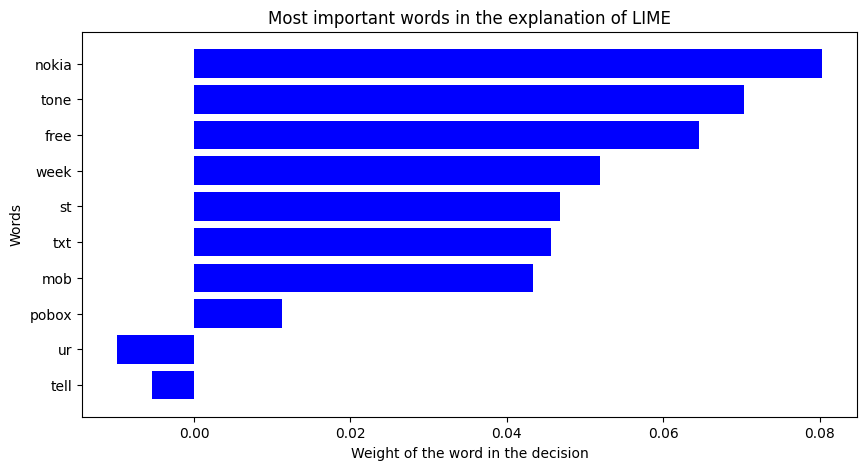

In [29]:
# Separar palavras e pesos
words, weights = zip(*lime_features)

# Criar gráfico de barras
plt.figure(figsize=(10, 5))
plt.barh(words, weights, color="blue")
plt.xlabel("Weight of the word in the decision")
plt.ylabel("Words")
plt.title("Most important words in the explanation of LIME")
plt.gca().invert_yaxis()  # Inverter para mostrar a palavra mais importante no topo
plt.show()

In [30]:
# Obter as palavras mais importantes e seus pesos no geral
words_weights = explanation.as_list()

# Imprimir as palavras e pesos
for word, weight in words_weights:
    print(f"{word}: {weight}")

nokia: 0.0802393893425981
tone: 0.07033750773337374
free: 0.06455672697197086
week: 0.05184038302475236
st: 0.04679184663347087
txt: 0.04562413440107254
mob: 0.0432715581596525
pobox: 0.011233232754800497
ur: -0.009833475327236076
tell: -0.0054366342247307705


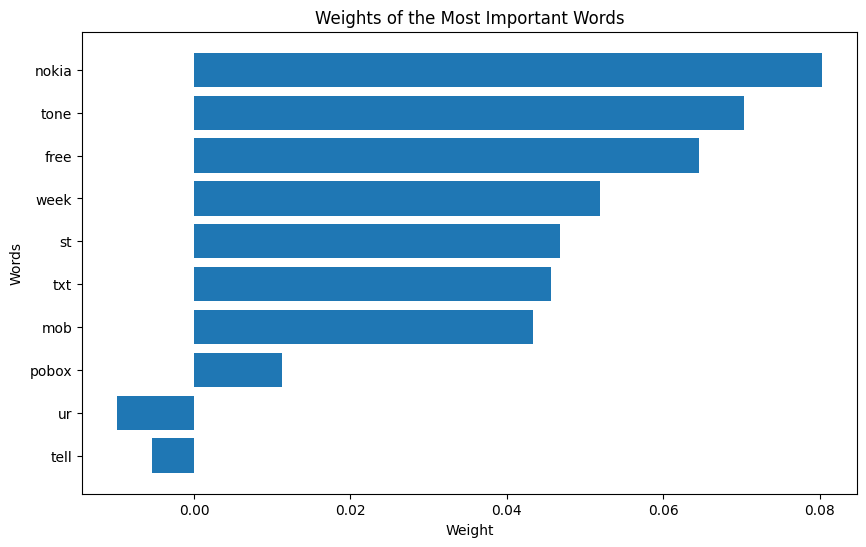

In [31]:
# Obter as palavras mais importantes e seus pesos no geral
words_weights = explanation.as_list()

# Separar palavras e pesos em listas separadas
words = [word for word, weight in words_weights]
weights = [weight for word, weight in words_weights]

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))  # Ajustar o tamanho da figura, se necessário
plt.barh(words, weights)
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Weights of the Most Important Words")
plt.gca().invert_yaxis()  # Inverter o eixo y para que as palavras mais importantes estejam no topo
plt.show()

**Attention Viz**

In [32]:
le.classes_

array(['ham', 'spam'], dtype=object)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
A classe prevista para o texto é o índice: 0

Palavras do exemplo e seus pesos na decisão da classe prevista (LSTM):
      Feature    Weight
837      park  0.133622
3157  measure -0.008828


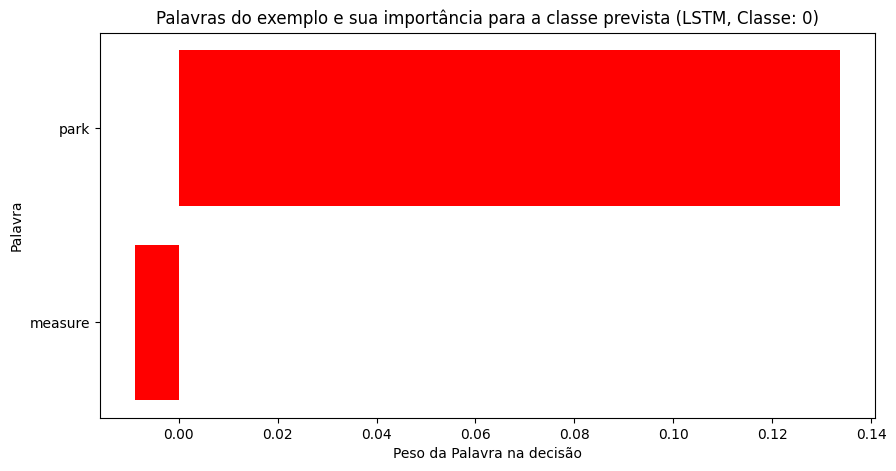

In [33]:
# Definir o texto de exemplo
sample_text = "preliminary estimation technology park measure square meter"

# **Etapa 1: Calcular a importância das palavras para cada classe do modelo LSTM**

# Obter os pesos da camada de Embedding
# Supondo que a camada de embedding é a primeira (índice 0)
embedding_weights = model.layers[0].get_weights()[0]

# Usar tokenizer.index_word para obter as palavras a partir dos índices
nomes_das_features = [tokenizer.index_word.get(i, '<OOV>') for i in range(1, embedding_weights.shape[0] + 1)]

# Obter os pesos da camada Dense (a última camada de saída)
dense_weights = model.layers[-1].get_weights()[0]

# Calcular a importância das palavras para cada classe
num_classes = dense_weights.shape[1]  # Número de classes de saída
importancias_das_features = []
for class_index in range(num_classes):
    # Obter os pesos da camada Dense para a classe atual
    class_weights = dense_weights[:, class_index]

    # Calcular a importância das palavras multiplicando os pesos da camada Dense pelos pesos da camada de Embedding
    word_importances = np.dot(embedding_weights, class_weights)

    importancias_da_classe = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
    importancias_da_classe = importancias_da_classe.sort_values(by='Weight', ascending=False)
    importancias_das_features.append(importancias_da_classe)

# **Etapa 2: Prever a classe do sample_text usando o modelo LSTM**

MAX_SEQUENCE_LENGTH = 100 # Substitua pelo valor correto do seu modelo

# Pré-processar o texto de exemplo para o modelo LSTM
sequence = tokenizer.texts_to_sequences([sample_text])
padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)

# Fazer a previsão
prediction = model.predict(padded_sequence)

# Obter o índice da classe prevista (a com maior probabilidade)
predicted_class_index = np.argmax(prediction[0])

print(f"A classe prevista para o texto é o índice: {predicted_class_index}")

# **Etapa 3: Visualizar a importância das palavras para a classe prevista**

# Selecionar o DataFrame de importâncias da classe prevista
importancias_da_classe_prevista = importancias_das_features[predicted_class_index]

# Criar um conjunto com as palavras do exemplo, para uma busca mais eficiente
# A regex `\b\w+\b` garante que apenas palavras sejam extraídas, ignorando pontuação
palavras_exemplo = set(re.findall(r'\b\w+\b', sample_text.lower()))

# Filtrar o DataFrame para incluir apenas as palavras que estão no texto de exemplo
importancias_exemplo_lstm = importancias_da_classe_prevista[
    importancias_da_classe_prevista['Feature'].apply(lambda x: x in palavras_exemplo)
]
importancias_exemplo_lstm = importancias_exemplo_lstm.sort_values(by='Weight', ascending=False)

# Exibir as importâncias das palavras do exemplo
print("\nPalavras do exemplo e seus pesos na decisão da classe prevista (LSTM):")
print(importancias_exemplo_lstm[['Feature', 'Weight']])

# **Etapa 4: Plotar o gráfico**

plt.figure(figsize=(10, 5))
plt.barh(importancias_exemplo_lstm['Feature'], importancias_exemplo_lstm['Weight'], color="red")
plt.xlabel("Peso da Palavra na decisão")
plt.ylabel("Palavra")
plt.title(f"Palavras do exemplo e sua importância para a classe prevista (LSTM, Classe: {predicted_class_index})")
plt.gca().invert_yaxis()
plt.show()

In [34]:
class_index = 0
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_negativas = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
importancias_negativas = importancias_negativas.sort_values(by='Weight', ascending=False)

print("Most important features for the Negative class:")
print(importancias_negativas.head(20))

Most important features for the Negative class:
         Feature    Weight
0          <OOV>  1.872574
2650         evn  0.382731
187         line  0.362418
87          said  0.351740
1157         num  0.350529
36           lor  0.345570
61          work  0.340352
4146  correction  0.334534
1574      favour  0.334030
1125         due  0.333490
3856  toothpaste  0.332703
816        trust  0.331979
2195       grave  0.327165
499          far  0.325020
724       laptop  0.321702
8           free  0.318384
1068  appreciate  0.316435
189      meeting  0.314638
2896     wearing  0.312756
348         code  0.311953


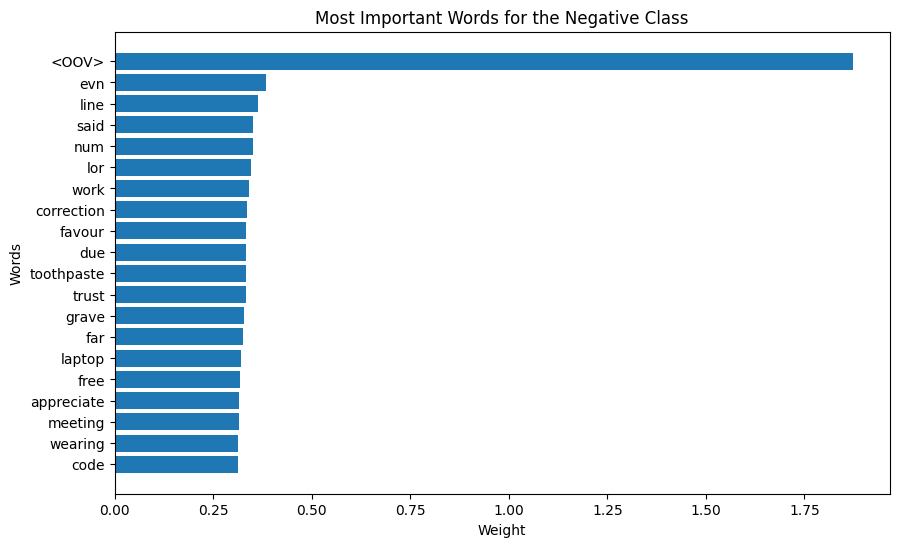

In [35]:
# Criar gráfico de barras para palavras negativas
plt.figure(figsize=(10, 6))
plt.barh(importancias_negativas['Feature'][:20], importancias_negativas['Weight'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Negative Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()

In [36]:
class_index = 1
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_neutras = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
importancias_neutras = importancias_neutras.sort_values(by='Weight', ascending=False)

print("Most important features for the Neutral class:")
print(importancias_neutras.head(20))

Most important features for the Neutral class:
      Feature    Weight
4223    magic  0.582294
249     guess  0.565364
33      sorry  0.482994
43      later  0.467439
710        an  0.457729
59    message  0.399397
1840    bcums  0.390795
435   attempt  0.382854
508      busy  0.381412
334       til  0.377610
333     price  0.364023
914        mm  0.358712
472     smoke  0.356397
132       per  0.356042
1022     howz  0.355060
547        gd  0.354443
201      long  0.344703
2074  explain  0.339967
393      stay  0.339864
424     dream  0.334531


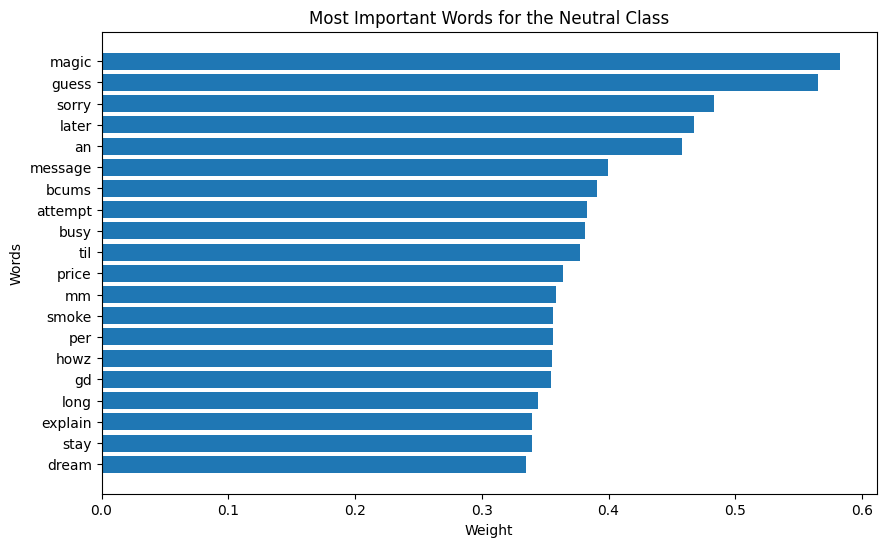

In [37]:
# Criar gráfico de barras para palavras neutras
plt.figure(figsize=(10, 6))
plt.barh(importancias_neutras['Feature'][:20], importancias_neutras['Weight'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Neutral Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()

In [38]:
class_index = 2
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_positivas = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
importancias_positivas = importancias_positivas.sort_values(by='Weight', ascending=False)

print("Most important features for the Positive class:")
print(importancias_positivas.head(20))

Most important features for the Positive class:
                          Feature    Weight
979                         issue  0.219741
629                         march  0.207959
33                          sorry  0.200396
30                         mobile  0.174586
3                              im  0.174127
912                            ge  0.166420
2983                         mall  0.161597
133                             x  0.160271
895                            mp  0.156936
403                         there  0.154404
81                              e  0.151534
36                            lor  0.150450
1022                         howz  0.150041
1191                        group  0.147907
234                           car  0.147274
3778                         ofwd  0.146567
1702                        china  0.146143
603                          exam  0.143662
1723                      anyways  0.143194
1769  pmsgrcvdhgsuitelandsrowwjhl  0.142772


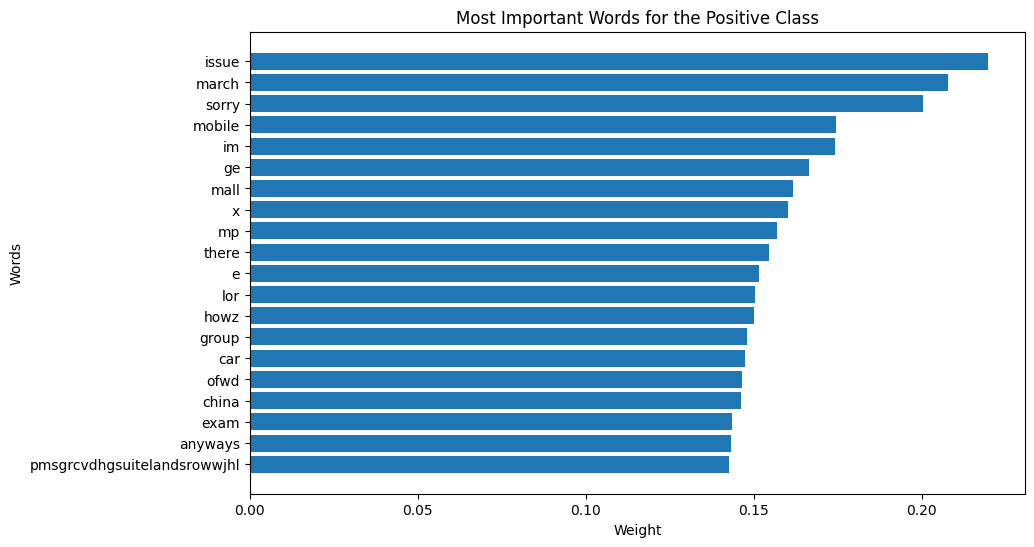

In [39]:
# Criar gráfico de barras para palavras positivas
plt.figure(figsize=(10, 6))
plt.barh(importancias_positivas['Feature'][:20], importancias_positivas['Weight'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Positive Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()